# 06 Antialiasing

* 하나의 픽셀 별로 여러 ray를 쏘고 blending해서 영상의 aliasing을 줄입니다.

# Aliasing

Aliasing은 이미지에서 물체의 경계 부분에서 일직선으로 그려져야 할 부분이 계단 형태로 지그재그로 그려지는 현상입니다.
이전 챕터들의 결과에서도 확인할 수 있습니다.

<center>
<img src="./images/aliasing.png" width="700px" title="aliasing"/>
</center>

Aliasing은 신호 처리에서 실제 신호의 주기(frequency)보다 샘플링의 주기가 낮을 때 발생합니다. 
아래 그림처럼 검은색 신호의 주기보다 느린 주기(빨간점)로 샘플링을 해서 신호를 복원하면 빨간 점선처럼 신호가 만들어 집니다.

<center>
<img src="./images/signal.png" width="400px" title="signal"/>
</center>

간단하게는 aliasing은 해상도가 낮으면 발생한다고 볼 수 있습니다.

## Antialiasing

Aliasing 문제를 해결하기 위한 antialiasing에는 주로 샘플링 방법을 사용합니다.
여기서는 픽셀마다 샘플링 횟수를 늘리고 값을 평균내는 방식으로 해결합니다.

In [2]:
from typing import List
import sys
from tqdm import tqdm

import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt


infinity = sys.float_info.max

색상 값을 정규화하는 normalize_color를 추가합니다.
* 이제 한 픽셀마다 여러 ray가 컬러를 샘플링해서 더하기 때문에 샘플링 갯수로 나누어 주는 함수입니다.

In [3]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec) + eps)


def blend(color1: np.array, color2: np.array, t: float):
    return (1.0 - t) * color1 + t * color2


def normalize_color(image: np.array, samples_per_pixel: int):
    # divide the color by the number of samples.
    scale = 1.0 / samples_per_pixel
    return scale * image

다른 클래스과 함수들의 구현은 이전과 동일합니다.

In [4]:
class Ray:
    def __init__(self, origin: np.array, direction: np.array) -> None:
        self.origin: np.array = origin
        self.direction: np.array = normalize(direction)

    def at(self, t: float) -> np.array:
        return self.origin + t * self.direction

In [5]:
class HitRecord:
    def __init__(self, point: np.array, normal: np.array, t: float) -> None:
        self.point = point
        self.normal = normal
        self.t = t

    def set_face_normal(self, ray: Ray, outward_normal: np.array) -> None:
        is_front_face = np.dot(ray.direction, outward_normal) < 0
        self.normal = outward_normal if is_front_face else -outward_normal

In [6]:
class Hittable:
    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        raise NotImplementedError

In [7]:
class Sphere(Hittable):
    def __init__(self) -> None:
        self.center = np.zeros(3)
        self.radius = 1.0

    def __init__(self, center: np.array, radius: float) -> None:
        self.center = center
        self.radius = radius

    def hit(self, ray: Ray, t_min: float, t_max: float) -> bool:
        dir_center_to_origin = ray.origin - self.center

        a = np.dot(ray.direction, ray.direction)
        half_b = np.dot(dir_center_to_origin, ray.direction)
        c = np.dot(dir_center_to_origin, dir_center_to_origin) - self.radius**2.0

        discriminant = half_b**2 - a * c
        if discriminant < 0:
            return None
        sqrt_d = np.sqrt(discriminant)

        # find the nearest root that lies in the acceptable range.
        t = (-half_b - sqrt_d) / a
        if t < t_min or t_max < t:
            t = (-half_b + sqrt_d) / a
            if t < t_min or t_max < t:
                return None

        point = ray.at(t)
        outward_normal = (point - self.center) / self.radius
        hit_record = HitRecord(point=point, normal=outward_normal, t=t)
        hit_record.set_face_normal(ray=ray, outward_normal=outward_normal)

        return hit_record

In [8]:
class HittableList(Hittable):
    def __init__(self) -> None:
        self.objects: List[Hittable] = []

    def clear(self) -> None:
        self.objects.clear()

    def add(self, object: Hittable) -> None:
        self.objects.append(object)

    def hit(self, ray: Ray, t_min: float, t_max: float) -> HitRecord:
        record = None
        closest_so_far = t_max

        for object in self.objects:
            tmp_record = object.hit(ray=ray, t_min=t_min, t_max=closest_so_far)
            if tmp_record is not None:
                closest_so_far = tmp_record.t
                record = tmp_record

        return record

카메라 파라미터들과 함수를 Camera 클래스로 묶었습니다.
* get_ray 함수는 픽셀의 uv 좌표를 입력으로 주면 ray를 생성해 반환합니다.

In [9]:
class Camera:
    def __init__(self) -> None:
        self.aspect_ratio = 16.0 / 9.0
        self.viewport_height = 2.0
        self.viewport_width = self.aspect_ratio * self.viewport_height
        self.focal_length = 1.0

        self.origin = np.array([0.0, 0.0, 0.0])
        self.horizontal_vec = np.array([self.viewport_width, 0.0, 0.0])
        self.vertical_vec = np.array([0.0, self.viewport_height, 0.0])
        self.frontal_vec = np.array([0.0, 0.0, self.focal_length])
        self.lower_left_corner = (
            self.origin
            - self.horizontal_vec / 2.0
            - self.vertical_vec / 2.0
            - self.frontal_vec
        )

    def get_ray(self, u: float, v: float) -> Ray:
        return Ray(
            origin=self.origin,
            direction=(
                self.lower_left_corner + u * self.horizontal_vec + v * self.vertical_vec
            )
            - self.origin,
        )

In [10]:
def ray_color(ray: Ray, world: Hittable) -> np.array:
    color = np.ones(3)
    record = world.hit(ray=ray, t_min=0.0, t_max=infinity)
    if record is not None:
        return 0.5 * (record.normal + color)

    t = 0.5 * (ray.direction[1] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    return blend(color1=color1, color2=color2, t=t)

다른 부분은 이전과 동일하고 samples_per_pixels를 추가합니다.
* samples_per_pixels은 하나의 픽셀마다 몇개의 ray를 만들지를 의미합니다.
* samples_per_pixels이 1이면 이전과 동일한 결과를 만듭니다.
* samples_per_pixels이 커질수록 계산시간은 늘어나지만 물체의 경계 부분이 부드러워 지는 것을 확인할 수 있습니다.

In [11]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)
samples_per_pixel = 10

image = np.zeros([image_height, image_width, 3])

In [12]:
# world
world = HittableList()
world.add(Sphere(center=np.array([0.0, 0.0, -1.0]), radius=0.5))
world.add(Sphere(center=np.array([0.0, -100.5, -1.0]), radius=100.0))

In [13]:
# camera
camera = Camera()

이전까지는 각 ray가 픽셀의 중심을 지나간다고 가정했습니다. 지금은 이전 구현과 다르게 여러 ray가 픽셀의 여러 지점을 통과합니다.
1. 하나의 픽셀에 대해서 samples_per_pixel 만큼 랜덤한 ray들을 생성해서 색상을 계산해서 누적
2. 누적된 색상 값을 samples_per_pixel 으로 나누어서 정규화합니다.
<img src="./images/pixel_samples.png" width="600px" title="hit_case_1_1"/>

In [14]:
%%time

for row in tqdm(range(image_height)):
  for col in range(image_width):
    for _ in range(samples_per_pixel):
      u = (col + np.random.uniform(low=-0.5, high=0.5)) / (image_width - 1)
      v = (row + np.random.uniform(low=-0.5, high=0.5)) / (image_height - 1)
      ray = camera.get_ray(u, v)
      image[row, col] += ray_color(ray=ray, world=world)

image = normalize_color(image, samples_per_pixel=samples_per_pixel)

100%|██████████| 180/180 [00:14<00:00, 12.15it/s]

CPU times: total: 14.8 s
Wall time: 14.8 s


이미지의 경계 부분의 계단 현상이 줄어든 것을 확인합니다.

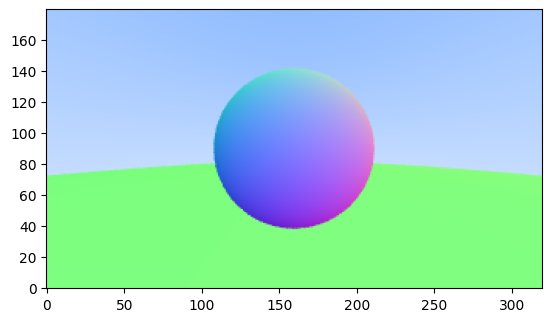

In [15]:
plt.imshow(image, origin="lower")
plt.show()